In [62]:
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

In [63]:
# Source: http://web.mta.info/developers/turnstile.html
def get_data(week_nums):
    url = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt"
    dfs = []
    for week_num in week_nums:
        file_url = url.format(week_num)
        dfs.append(pd.read_csv(file_url))
    return pd.concat(dfs)
        
week_nums = [200411, 200418, 200425, 200502, 200509, 200516, 200523, 200530, 200606, 200613, 200620, 200627]
# df2020 = get_data(week_nums)

In [64]:
# Load datasets
station_data = pd.read_csv('stations.csv') # Locations of stations
census_block_loc = pd.read_csv('census_block_loc.csv') # Locations of census block(sub-level of tract)
nyc_census_tracts = pd.read_csv('nyc_census_tracts.csv') # Census tract code and Poverty proportion
df2020 = pd.read_pickle('df2020.pkl')
# Plan:
# 1. Get the census tract number we want(nyc_census_tracts)
# 2. Find the blocks within the census tract(census_block_loc)
# 3. Find the station+line combo's within those blocks(station_data)
# 4. Find the matching station+line combo's in MTA dataset(df2020)

In [65]:
# Top 4 poverty census tracts
nyc_census_tracts.sort_values('Poverty', ascending=False)[['CensusTract','County','Borough','Poverty']].head(4)
tract_number = 36061014300

In [66]:
# Find blocks within the top 1 poverty census tract
blocks = census_block_loc[(census_block_loc.BlockCode.map(lambda x: x//10000) == tract_number)].sort_values('BlockCode')
print(len(blocks))

53


In [67]:
station_data.head()

,Unnamed: 0,Station ID,Complex ID,GTFS Stop ID,Division,Line,Stop Name,Borough,Daytime Routes,Structure,GTFS Latitude,GTFS Longitude,North Direction Label,South Direction Label,Census Block
0,0,1,1,R01,BMT,Astoria,Astoria - Ditmars Blvd,Q,N W,Elevated,40.775036,-73.912034,NaN,Manhattan,360810115002001
1,1,2,2,R03,BMT,Astoria,Astoria Blvd,Q,N W,Elevated,40.770258,-73.917843,Ditmars Blvd,Manhattan,360810125001009
2,2,3,3,R04,BMT,Astoria,30 Av,Q,N W,Elevated,40.766779,-73.921479,Astoria - Ditmars Blvd,Manhattan,360810063001001
3,3,4,4,R05,BMT,Astoria,Broadway,Q,N W,Elevated,40.761820,-73.925508,Astoria - Ditmars Blvd,Manhattan,360810059003000
4,4,5,5,R06,BMT,Astoria,36 Av,Q,N W,Elevated,40.756804,-73.929575,Astoria - Ditmars Blvd,Manhattan,360810053004002


In [68]:
# Find the stations within the top 1 census tract using the blocks' lon-lat
stations = station_data[station_data['Census Block']//10000 == tract_number]

In [69]:
# There are 7 stations in the top 1 census tract
stop_name_list = list(stations['Stop Name'].unique())
stop_name_list 

['5 Av/59 St', '96 St', '86 St', '81 St - Museum of Natural History', '72 St']

In [70]:
set(df2020.STATION)

{'1 AV',
 '103 ST',
 '103 ST-CORONA',
 '104 ST',
 '110 ST',
 '111 ST',
 '116 ST',
 '116 ST-COLUMBIA',
 '121 ST',
 '125 ST',
 '135 ST',
 '137 ST CITY COL',
 '138/GRAND CONC',
 '14 ST',
 '14 ST-UNION SQ',
 '145 ST',
 '149/GRAND CONC',
 '14TH STREET',
 '15 ST-PROSPECT',
 '155 ST',
 '157 ST',
 '161/YANKEE STAD',
 '163 ST-AMSTERDM',
 '167 ST',
 '168 ST',
 '169 ST',
 '170 ST',
 '174 ST',
 '174-175 STS',
 '175 ST',
 '176 ST',
 '18 AV',
 '18 ST',
 '181 ST',
 '182-183 STS',
 '183 ST',
 '190 ST',
 '191 ST',
 '2 AV',
 '20 AV',
 '207 ST',
 '21 ST',
 '21 ST-QNSBRIDGE',
 '215 ST',
 '219 ST',
 '225 ST',
 '23 ST',
 '231 ST',
 '233 ST',
 '238 ST',
 '25 AV',
 '25 ST',
 '28 ST',
 '3 AV',
 '3 AV 138 ST',
 '3 AV-149 ST',
 '30 AV',
 '33 ST',
 '33 ST-RAWSON ST',
 '34 ST-HERALD SQ',
 '34 ST-HUDSON YD',
 '34 ST-PENN STA',
 '36 AV',
 '36 ST',
 '39 AV',
 '4 AV-9 ST',
 '40 ST LOWERY ST',
 '42 ST-BRYANT PK',
 '42 ST-PORT AUTH',
 '45 ST',
 '46 ST',
 '46 ST BLISS ST',
 '47-50 STS ROCK',
 '49 ST',
 '4AV-9 ST',
 '5 AV

In [71]:
# Manually find the 5 stations from MTA dataset that match the stations' names in Stations.csv
top1_stations = \
['5 AV/59 ST',
 '96 ST',
 '86 ST',
 '81 ST-MUSEUM',
 '72 ST'] 

In [72]:
# For each Stop Name(STATION), there is a list of Daytime Routes(LINENAME) in Stations.csv
stations.groupby(['Stop Name', 'Daytime Routes']).count()

,,Unnamed: 0,Station ID,Complex ID,GTFS Stop ID,Division,Line,Borough,Structure,GTFS Latitude,GTFS Longitude,North Direction Label,South Direction Label,Census Block
Stop Name,Daytime Routes,,,,,,,,,,,,,
5 Av/59 St,N W R,1,1,1,1,1,1,1,1,1,1,1,1,1
72 St,B C,1,1,1,1,1,1,1,1,1,1,1,1,1
81 St - Museum of Natural History,B C,1,1,1,1,1,1,1,1,1,1,1,1,1
86 St,B C,1,1,1,1,1,1,1,1,1,1,1,1,1
96 St,B C,1,1,1,1,1,1,1,1,1,1,1,1,1


In [73]:
# For each STATION, there is a list of LINENAME's in MTA dataset (We need to filter out irrelevant STATION+LINENAME's)
mta = df2020[df2020.STATION.map(lambda x: x in top1_stations)]
mta.groupby(['STATION','LINENAME']).count()

C/A  UNIT   SCP  DIVISION  DATE  TIME  DESC  ENTRIES  \
STATION      LINENAME                                                          
5 AV/59 ST   NQRW      3523  3523  3523      3523  3523  3523  3523     3523   
72 ST        123       5544  5544  5544      5544  5544  5544  5544     5544   
             BC        1764  1764  1764      1764  1764  1764  1764     1764   
81 ST-MUSEUM BC        2515  2515  2515      2515  2515  2515  2515     2515   
86 ST        1         3529  3529  3529      3529  3529  3529  3529     3529   
             456       6027  6027  6027      6027  6027  6027  6027     6027   
             BC        3024  3024  3024      3024  3024  3024  3024     3024   
             N         1008  1008  1008      1008  1008  1008  1008     1008   
             R         2273  2273  2273      2273  2273  2273  2273     2273   
96 ST        123       5780  5780  5780      5780  5780  5780  5780     5780   
             6         1536  1536  1536      1536  1536  1536  1536     1536   
             BC        2016  2016  2016      2016  2016  2016  2016     2016   

                       EXITS                                                                 
STATION      LINENAME                                                                        
5 AV/59 ST   NQRW                                                   3523                     
72 ST        123                                                    5544                     
             BC                                                     1764                     
81 ST-MUSEUM BC                                                     2515                     
86 ST        1                                                      3529                     
             456                                                    6027                     
             BC                                                     3024                     
             N                                                      1008                     
             R                                                      2273                     
96 ST        123                                                    5780                     
             6                                                      1536                     
             BC                                                     2016

In [74]:
# Reformat values of 'Daytime Routes' and 'Stop Name' as 'LINENAME' and 'STATION' from MTA dataset
pd.options.mode.chained_assignment = None  # default='warn'

stations['Daytime Routes'] = stations['Daytime Routes'].apply(lambda x: x.replace(" ",""))

for index in range(len(stop_name_list)):
    stations.loc[stations['Stop Name'] == stop_name_list[index], 'Stop Name'] = top1_stations[index]
stations.head()

,Unnamed: 0,Station ID,Complex ID,GTFS Stop ID,Division,Line,Stop Name,Borough,Daytime Routes,Structure,GTFS Latitude,GTFS Longitude,North Direction Label,South Direction Label,Census Block
7,7,8,8,R13,BMT,Astoria,5 AV/59 ST,M,NWR,Subway,40.764811,-73.973347,Queens,Downtown & Brooklyn,360610143001051
156,156,157,157,A19,IND,8th Av - Fulton St,96 ST,M,BC,Subway,40.791642,-73.964696,Uptown & The Bronx,Downtown & Brooklyn,360610143001014
157,157,158,158,A20,IND,8th Av - Fulton St,86 ST,M,BC,Subway,40.785868,-73.968916,Uptown & The Bronx,Downtown & Brooklyn,360610143001015
158,158,159,159,A21,IND,8th Av - Fulton St,81 ST-MUSEUM,M,BC,Subway,40.781433,-73.972143,Uptown & The Bronx,Downtown & Brooklyn,360610143001029
159,159,160,160,A22,IND,8th Av - Fulton St,72 ST,M,BC,Subway,40.775594,-73.976410,Uptown & The Bronx,Downtown & Brooklyn,360610143001038


In [75]:
# Store the combinations in 'locations' variable
from collections import defaultdict
locations = defaultdict(list)
for station_name in top1_stations:
    stations_set = set(stations.loc[stations['Stop Name'] == station_name, 'Daytime Routes'])
    mta_set = set(mta.loc[mta.STATION == station_name, 'LINENAME'])
    for daytime_route in stations_set:
        mask = [set(daytime_route).issubset(set(item)) for item in mta_set]
        locations[station_name] += [target for boolean, target in zip(mask, mta_set) if boolean]
locations

defaultdict(list,
            {'5 AV/59 ST': ['NQRW'],
             '96 ST': ['BC'],
             '86 ST': ['BC'],
             '81 ST-MUSEUM': ['BC'],
             '72 ST': ['BC']})

In [76]:
# Finally, find the rows in MTA dataset corresponding to each combo
final_df = pd.DataFrame()
for station_name, line_list in locations.items():
    for line in line_list:
        final_df = final_df.append(mta[(mta.LINENAME == line) & (mta.STATION == station_name)])
final_df.groupby(['STATION','LINENAME']).count()

,,C/A,UNIT,SCP,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
STATION,LINENAME,,,,,,,,,
5 AV/59 ST,NQRW,3523,3523,3523,3523,3523,3523,3523,3523,3523
72 ST,BC,1764,1764,1764,1764,1764,1764,1764,1764,1764
81 ST-MUSEUM,BC,2515,2515,2515,2515,2515,2515,2515,2515,2515
86 ST,BC,3024,3024,3024,3024,3024,3024,3024,3024,3024
96 ST,BC,2016,2016,2016,2016,2016,2016,2016,2016,2016


In [77]:
# Create new column 'STATION_LINENAME' in final_df and df2020
final_df['STATION_LINENAME'] = list(zip(final_df.STATION, final_df.LINENAME))
df2020['STATION_LINENAME'] = list(zip(df2020.STATION, df2020.LINENAME))
print(final_df.STATION_LINENAME.unique())
final_df.head()

[('5 AV/59 ST', 'NQRW') ('96 ST', 'BC') ('86 ST', 'BC')
 ('81 ST-MUSEUM', 'BC') ('72 ST', 'BC')]


,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,STATION_LINENAME
462,A006,R079,00-00-00,5 AV/59 ST,NQRW,BMT,05/16/2020,02:00:00,REGULAR,4290343,7406275,"(5 AV/59 ST, NQRW)"
463,A006,R079,00-00-00,5 AV/59 ST,NQRW,BMT,05/16/2020,06:00:00,REGULAR,4290343,7406278,"(5 AV/59 ST, NQRW)"
464,A006,R079,00-00-00,5 AV/59 ST,NQRW,BMT,05/16/2020,10:00:00,REGULAR,4290347,7406300,"(5 AV/59 ST, NQRW)"
465,A006,R079,00-00-00,5 AV/59 ST,NQRW,BMT,05/16/2020,14:00:00,REGULAR,4290357,7406326,"(5 AV/59 ST, NQRW)"
466,A006,R079,00-00-00,5 AV/59 ST,NQRW,BMT,05/16/2020,18:00:00,REGULAR,4290387,7406350,"(5 AV/59 ST, NQRW)"


# Traffic

In [78]:
final_df['DATETIME'] = final_df[['DATE', 'TIME']].apply(lambda x: ' '.join(x), axis = 1)
final_df['DIFF'] = final_df.groupby(['DATE','C/A','UNIT','SCP','STATION'])['ENTRIES'].transform(pd.Series.diff)

In [79]:
final_df.sort_values('DIFF', ascending=False)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,STATION_LINENAME,DATETIME,DIFF
790,A006,R079,00-03-02,5 AV/59 ST,NQRW,BMT,06/25/2020,18:00:00,REGULAR,969303,817042,"(5 AV/59 ST, NQRW)",06/25/2020 18:00:00,245.0
48750,N039,R251,01-00-01,96 ST,BC,IND,06/12/2020,20:00:00,REGULAR,306690,150710,"(96 ST, BC)",06/12/2020 20:00:00,241.0
48732,N039,R251,01-00-01,96 ST,BC,IND,06/09/2020,20:00:00,REGULAR,305142,150409,"(96 ST, BC)",06/09/2020 20:00:00,228.0
48738,N039,R251,01-00-01,96 ST,BC,IND,06/10/2020,20:00:00,REGULAR,305642,150507,"(96 ST, BC)",06/10/2020 20:00:00,219.0
772,A006,R079,00-03-02,5 AV/59 ST,NQRW,BMT,06/22/2020,18:00:00,REGULAR,968097,815368,"(5 AV/59 ST, NQRW)",06/22/2020 18:00:00,216.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50177,N046,R281,00-06-01,72 ST,BC,IND,06/22/2020,00:00:00,REGULAR,415726,474408,"(72 ST, BC)",06/22/2020 00:00:00,NaN
50183,N046,R281,00-06-01,72 ST,BC,IND,06/23/2020,00:00:00,REGULAR,415814,474567,"(72 ST, BC)",06/23/2020 00:00:00,NaN
50189,N046,R281,00-06-01,72 ST,BC,IND,06/24/2020,00:00:00,REGULAR,415927,474748,"(72 ST, BC)",06/24/2020 00:00:00,NaN
50195,N046,R281,00-06-01,72 ST,BC,IND,06/25/2020,00:00:00,REGULAR,416038,474919,"(72 ST, BC)",06/25/2020 00:00:00,NaN


In [80]:
# Station+line's in the census tract with 100% of people under poverty level (about 1% of all turnstiles in the past 12 wks)
print(len(final_df.groupby(['C/A', 'UNIT', 'SCP', 'STATION']).count())) # 51 turnstiles in top 1 tract
len(df2020.groupby(['C/A', 'UNIT', 'SCP', 'STATION']).count()) # 4961 turnstiles in total

51


4961

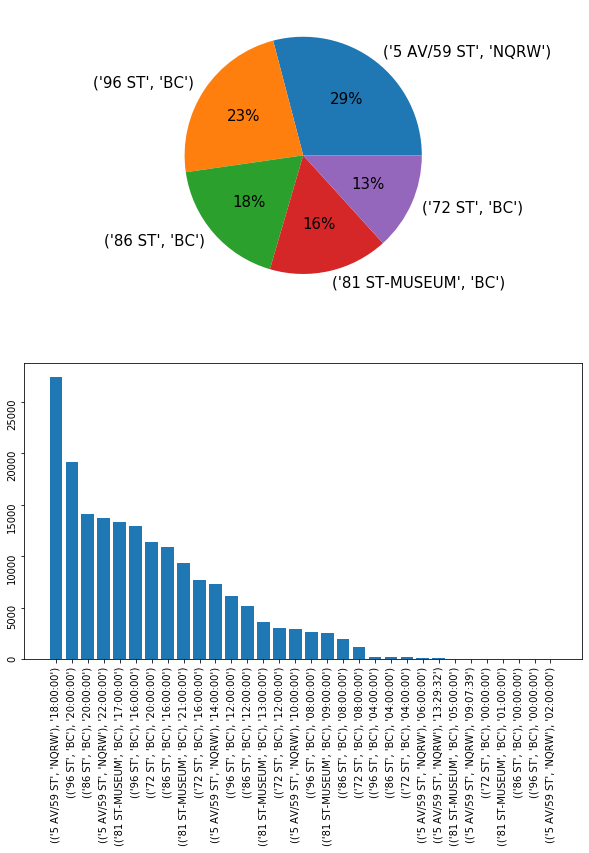

In [81]:
diff_statline_time = \
final_df.groupby(['STATION_LINENAME', 'TIME']).sum()['DIFF'].sort_values(ascending = False) # Entries per statline & time in descending order
labels = diff_statline_time.index.map(lambda x: str(x))

diff_statline = \
final_df.groupby(['STATION_LINENAME']).sum()['DIFF'].sort_values(ascending = False) # Entries per statline in descending order

fig, ax = plt.subplots(2, 1, figsize = (10, 6))
fig.set_figwidth(10)
fig.set_figheight(12)

ax[0].pie(diff_statline, labels = diff_statline.index, 
          autopct='%1.0f%%', textprops = {'fontsize': 15});# ('5 AV/59 ST', 'NQRW') and ('81 ST-MUSEUM', 'BC') account for 77% of the traffic
ax[1].bar(labels, diff_statline_time)
ax[1].tick_params(labelrotation=90);

In [82]:
print(list(round(100*diff_statline_time/sum(diff_statline_time),1)), 'in %')

[15.4, 10.8, 7.9, 7.7, 7.5, 7.3, 6.4, 6.1, 5.2, 4.3, 4.1, 3.5, 2.9, 2.0, 1.7, 1.7, 1.5, 1.4, 1.1, 0.7, 0.1, 0.1, 0.1, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] in %


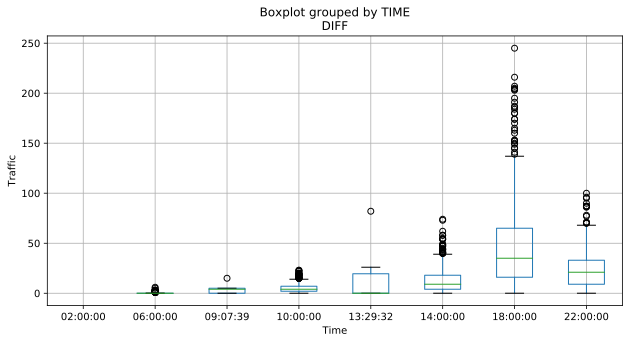

In [102]:
%config InlineBackend.figure_format = 'svg'
final_df.loc[final_df.STATION_LINENAME == ('5 AV/59 ST', 'NQRW'), ['TIME','DIFF']].boxplot(by = ['TIME'],figsize=(10,5))
plt.xlabel('Time'); plt.ylabel('Traffic')